In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zf = "/content/drive/MyDrive/dataset.zip"
target_dir = "/content/drive/MyDrive/new dataset"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/new dataset/train'
test_path = '/content/drive/MyDrive/new dataset/test'
valid_path = '/content/drive/MyDrive/new dataset/val'

batch_size = 16

img_height = 500
img_width = 500

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


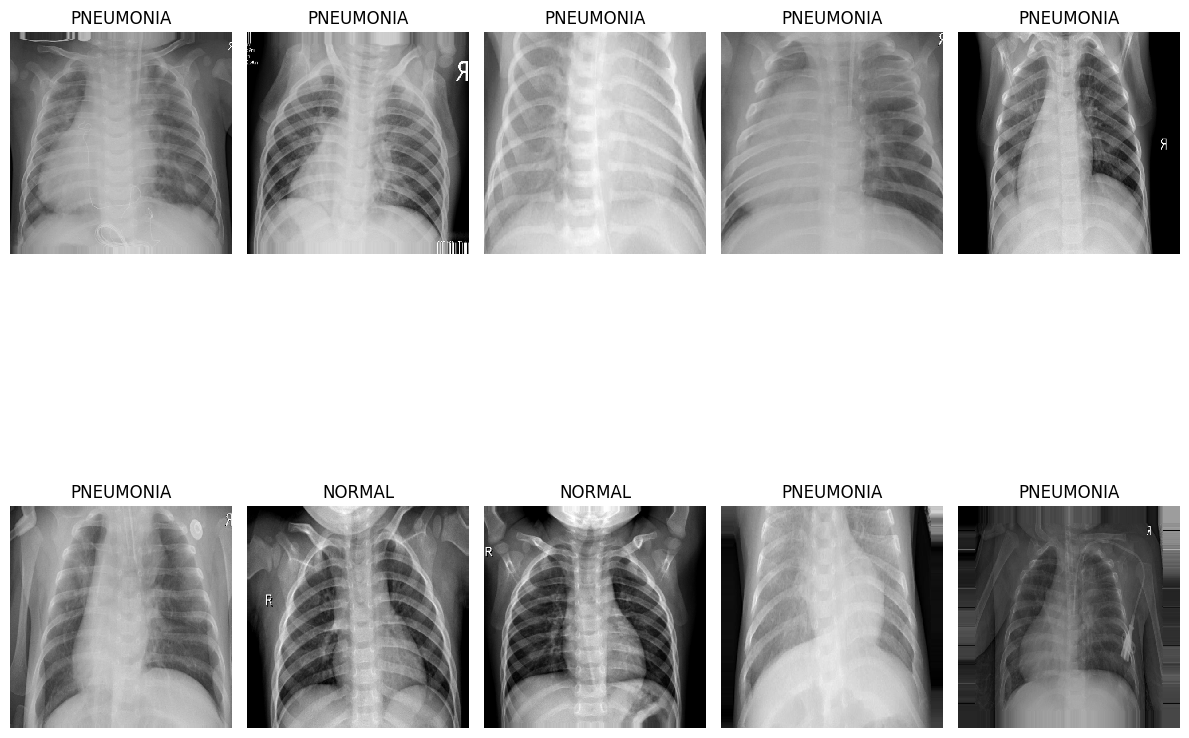

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Define a dictionary to map class labels to class names
dic = {0: 'NORMAL', 1: 'PNEUMONIA'}

for i in range(0, 10):
    plt.subplot(2, 5, i + 1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        class_name = dic.get(Y_batch[0])
        plt.title(class_name)
        plt.axis('off')
        plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
        break

plt.tight_layout()
plt.show()


#Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]


Assigning Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
history = cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 501s 2s/step - loss: 0.4894 - accuracy: 0.7402 - val_loss: 0.4699 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 157s 596ms/step - loss: 0.2624 - accuracy: 0.8929 - val_loss: 0.2524 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 146s 557ms/step - loss: 0.2239 - accuracy: 0.9129 - val_loss: 0.2005 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 157s 599ms/step - loss: 0.2015 - accuracy: 0.9191 - val_loss: 0.1776 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - 145s 555ms/step - loss: 0.1875 - accuracy: 0.9296 - val_loss: 0.1648 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 6/25
262/262 [==============================] - 147s 562ms/step - loss: 0.1742 - accuracy: 0.9308 - val_loss: 0.1659 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 7/25
262/262 [=============================

In [ ]:
fp = "/content/drive/My Drive/cnn_new_model.h5"
cnn.save(fp)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

cnn = load_model(fp)

In [ ]:
# Save the history to a file
import pickle
with open("/content/drive/My Drive/training_history.pkl", 'wb') as history_file:
    pickle.dump(history.history, history_file)

<Axes: >

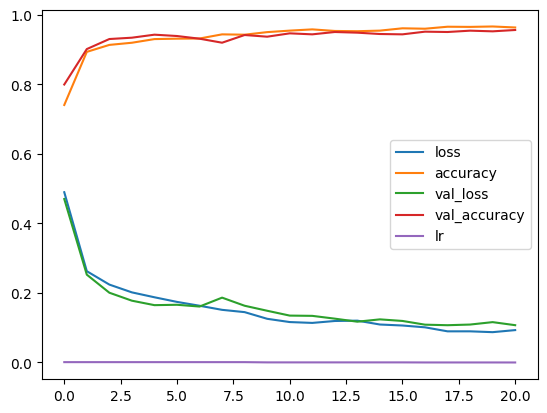

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load the model
cnn = load_model(fp)

# Load the training history
with open("/content/drive/My Drive/training_history.pkl", 'rb') as history_file:
    history = pickle.load(history_file)

# Plot the training history
import pandas as pd
pd.DataFrame(history).plot()


In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 131s 3s/step - loss: 0.2983 - accuracy: 0.9151
The testing accuracy is : 91.50640964508057 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 5s 123ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

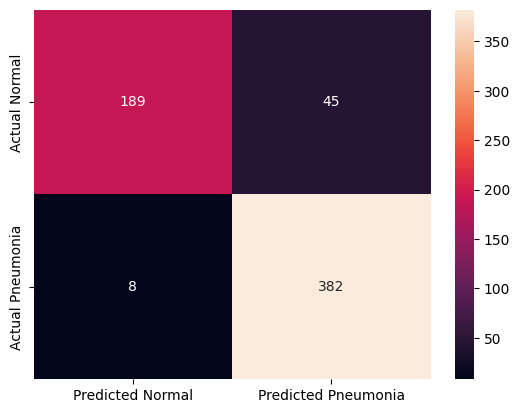

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))


              precision    recall  f1-score   support

      NORMAL       0.96      0.81      0.88       234
   PNEUMONIA       0.89      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


1/1 [==============================] - 0s 35ms/step


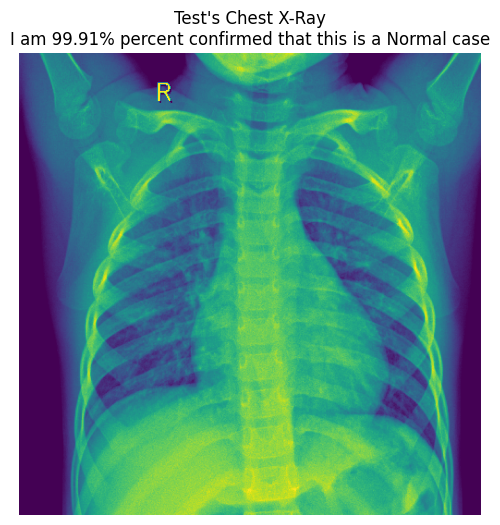

In [ ]:
import numpy as np
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd
# Testing with my own Chest X-Ray
path = '/content/drive/MyDrive/new dataset/train/normal/IM-0141-0001.jpeg'

from tensorflow.keras.preprocessing import image

test_img = image.load_img(path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_test_img = image.img_to_array(test_img)
pp_test_img = pp_test_img/255
pp_test_img = np.expand_dims(pp_test_img, axis=0)

#predict
test_preds= cnn.predict(pp_test_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if test_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(test_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-test_preds[0][0]))


plt.title("Test's Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_test_img))
plt.show()